In [2]:
# to save time when we don't need show images
show_images = False
show_final_image = True

In [3]:
import rasterio

# filepath = "downloads/S2B_MSIL2A_20210701T095029_N0301_R079_T34UDF_20210701T124116.SAFE/GRANULE/L2A_T34UDF_A022556_20210701T095030/IMG_DATA/R10m/T34UDF_20210701T095029"
filepath = "downloads/S2A_MSIL2A_20210716T095031_N0301_R079_T34UEF_20210716T120258.SAFE/GRANULE/L2A_T34UEF_A031679_20210716T095359/IMG_DATA/R10m/T34UEF_20210716T095031"

dataset = rasterio.open(filepath + '_B03_10m.jp2')
dataset2 = rasterio.open(filepath + '_B08_10m.jp2')

In [4]:
dataset.crs
dataset.crs.to_wkt()

'PROJCS["WGS 84 / UTM zone 34N",GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0,AUTHORITY["EPSG","8901"]],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AUTHORITY["EPSG","4326"]],PROJECTION["Transverse_Mercator"],PARAMETER["latitude_of_origin",0],PARAMETER["central_meridian",21],PARAMETER["scale_factor",0.9996],PARAMETER["false_easting",500000],PARAMETER["false_northing",0],UNIT["metre",1,AUTHORITY["EPSG","9001"]],AXIS["Easting",EAST],AXIS["Northing",NORTH],AUTHORITY["EPSG","32634"]]'

In [5]:
import matplotlib.pyplot as plt

image_band_1 = dataset.read(1)
if show_images:
    plt.imshow(image_band_1)
image_band_1

array([[643, 658, 645, ..., 659, 655, 685],
       [628, 638, 676, ..., 676, 688, 694],
       [585, 616, 665, ..., 716, 692, 722],
       ...,
       [760, 778, 756, ..., 483, 558, 511],
       [727, 745, 730, ..., 510, 518, 523],
       [738, 741, 708, ..., 520, 521, 474]], dtype=uint16)

In [6]:
image_band_2 = dataset2.read(1)
if show_images:
    plt.imshow(image_band_2)

In [7]:
import numpy as np

# map 0 - ~16000 to 0.0 - 1.0
image_band_1_norm = image_band_1 / np.max(np.abs(image_band_1))
image_band_2_norm = image_band_2 / np.max(np.abs(image_band_2))

# 1 or 0 (water or not)
image_ndwi = (image_band_1_norm - image_band_2_norm) // (image_band_1_norm + image_band_2_norm + np.ones((image_band_1_norm.shape[0], image_band_1_norm.shape[1]))) + np.ones((image_band_1_norm.shape[0], image_band_1_norm.shape[1]))

# water mask true or false
water_mask = image_ndwi > 0.1

# show
if show_images:
    plt.imshow(image_ndwi.astype('uint16'))

In [8]:
def load_sentinel_image(img_folder, filename, bands, scale):
    image = {}
    for band in bands:
        file = img_folder + 'R' + scale + 'm/' + filename + '_' + band + '_' + scale + 'm.jp2'
        print(f'Opening file {file}')
        ds = rasterio.open(file)
        image.update({band: ds.read(1)})

    return image


def display_rgb(img, b_r, b_g, b_b, alpha = 1., figsize = (10, 10)):
    rgb = np.stack([img[b_r], img[b_g], img[b_b]], axis = -1)
    rgb = rgb / rgb.max() * alpha
    plt.figure(figsize = figsize)
    plt.imshow(rgb)


img = load_sentinel_image(filepath[:filepath.index("IMG_DATA") + 9], filepath[filepath.index("IMG_DATA") + 14:], ['B02', 'B03', 'B04'], '10')

if show_images:
    fig, ax = plt.subplots(1, 3, figsize = (15, 5))
    ax[0].imshow(img['B02'], cmap = 'Blues_r')
    ax[1].imshow(img['B03'], cmap = 'Greens_r')
    ax[2].imshow(img['B04'], cmap = 'Reds_r')

    display_rgb(img, 'B04', 'B03', 'B02', alpha = 5.)

Opening file downloads/S2A_MSIL2A_20210716T095031_N0301_R079_T34UEF_20210716T120258.SAFE/GRANULE/L2A_T34UEF_A031679_20210716T095359/IMG_DATA/R10m/T34UEF_20210716T095031_B02_10m.jp2
Opening file downloads/S2A_MSIL2A_20210716T095031_N0301_R079_T34UEF_20210716T120258.SAFE/GRANULE/L2A_T34UEF_A031679_20210716T095359/IMG_DATA/R10m/T34UEF_20210716T095031_B03_10m.jp2
Opening file downloads/S2A_MSIL2A_20210716T095031_N0301_R079_T34UEF_20210716T120258.SAFE/GRANULE/L2A_T34UEF_A031679_20210716T095359/IMG_DATA/R10m/T34UEF_20210716T095031_B04_10m.jp2


In [9]:
def new_water_mask_downscale(old_mask, old_shape, new_shape):
    new_mask = np.full((new_shape, new_shape), False)
    for i in range(new_shape):
        for j in range(new_shape):
            new_mask[i][j] = old_mask[(old_shape // new_shape) * i][(old_shape // new_shape) * j]
    
    return new_mask

rgb = np.stack([img['B04'], img['B03'], img['B02']], axis = -1)
rgb = rgb / rgb.max() * 5.

if (water_mask.shape[0] != rgb.shape[0]):
    water_mask = new_water_mask_downscale(water_mask, water_mask.shape[0], rgb.shape[0])

rgb[water_mask] = [0.1, 0.1, 0.9]

if show_images:
    plt.figure(figsize = (7, 7))
    plt.imshow(rgb)

In [10]:
# from sklearn.cluster import KMeans
# water_indexes = np.transpose(water_mask.nonzero())
# clusters = KMeans(n_clusters=2, random_state=0).fit(water_indexes)
# clusters.labels_

In [11]:
from sklearn.cluster import DBSCAN
water_indexes = np.transpose(water_mask.nonzero())
clusters = DBSCAN(eps = 5.0, min_samples = 10, algorithm='kd_tree', n_jobs = -1).fit(water_indexes)
clusters.labels_

array([  0,   0,   0, ..., 199, 199, 199], dtype=int64)

In [12]:
# Filter no-clusters and small clusters
cluster_threshold = 8000
unique, counts = np.unique(clusters.labels_, return_counts = True)
cluster_indexes = dict(zip(unique, counts))
cluster_indexes_above_thre = {k: v for k, v in cluster_indexes.items() if v > cluster_threshold and k != -1}
cluster_indexes_above_thre

{0: 1891140,
 54: 42996,
 59: 14051,
 64: 83508,
 72: 9641,
 85: 11617,
 99: 13119,
 108: 34831,
 124: 24515,
 134: 40986,
 148: 35149,
 195: 9060}

In [13]:
cluster_mask = [idx in cluster_indexes_above_thre for idx in clusters.labels_]
water_indexes_image_coords = water_indexes[cluster_mask]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


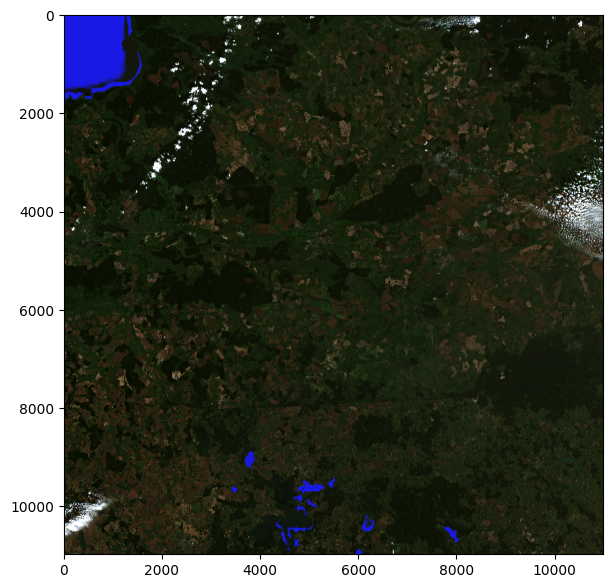

In [14]:
rgb = np.stack([img['B04'], img['B03'], img['B02']], axis=-1)
rgb = rgb/rgb.max() * 5

X = water_indexes_image_coords[:, 0]
Y = water_indexes_image_coords[:, 1]
mask_matrix = np.zeros((10980, 10980), dtype='bool')
mask_matrix[X, Y] = True
mask_matrix
rgb[mask_matrix] = [0.1, 0.1, 0.9]

if show_final_image:
    plt.figure(figsize = (7,7))
    plt.imshow(rgb)

In [15]:
print(mask_matrix)
print(water_indexes_image_coords)

[[ True  True  True ... False False False]
 [ True  True  True ... False False False]
 [ True  True  True ... False False False]
 ...
 [False False False ... False False False]
 [False False False ... False False False]
 [False False False ... False False False]]
[[    0     0]
 [    0     1]
 [    0     2]
 ...
 [10979  6058]
 [10979  6059]
 [10979  6060]]


In [16]:
data_transform = dataset.transform

move_to_real_coords = lambda water_idx: data_transform * water_idx

# print(water_indexes_real_coords)
# print(clusters.labels_)

zipped_water_clusters = zip(water_indexes, clusters.labels_)
water_cluster_points = {}
for point, cluster_idx in zipped_water_clusters:
    if cluster_idx not in water_cluster_points and cluster_idx in cluster_indexes_above_thre:
        water_cluster_points[cluster_idx] = point
    
print(len(water_cluster_points))
print(list(water_cluster_points.items())[:10])

water_indexes_real_coords = np.array([move_to_real_coords(np.array([xi[1], xi[0]])) for xi in water_cluster_points.values()])
water_indexes_real_coords

12
[(0, array([0, 0], dtype=int64)), (54, array([8883, 3799], dtype=int64)), (59, array([9410, 5496], dtype=int64)), (64, array([9480, 4921], dtype=int64)), (72, array([9590, 3450], dtype=int64)), (85, array([9853, 4982], dtype=int64)), (99, array([9989, 4772], dtype=int64)), (108, array([10172,  6191], dtype=int64)), (124, array([10294,  4378], dtype=int64)), (134, array([10352,  5055], dtype=int64))]


array([[ 499980., 6100020.],
       [ 537970., 6011190.],
       [ 554940., 6005920.],
       [ 549190., 6005220.],
       [ 534480., 6004120.],
       [ 549800., 6001490.],
       [ 547700., 6000130.],
       [ 561890., 5998300.],
       [ 543760., 5997080.],
       [ 550530., 5996500.],
       [ 578220., 5995800.],
       [ 560370., 5991330.]])

In [17]:
cluster_one_points = []

zipped_water_clusters = zip(water_indexes, clusters.labels_)
for point, cluster_idx in zipped_water_clusters:
    if cluster_idx == 0:
        cluster_one_points.append([point[1], point[0]]) 

cluster_one_points = np.array(cluster_one_points)

print(type(cluster_one_points))
print(len(cluster_one_points))


<class 'numpy.ndarray'>
1891140


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


0
hull length: 34
Area: 189114000 (m^2)
Area: 189.114 (km^2)
54
hull length: 31
Area: 4299600 (m^2)
Area: 4.2996 (km^2)
59
hull length: 18
Area: 1405100 (m^2)
Area: 1.4051 (km^2)
64
hull length: 26
Area: 8350800 (m^2)
Area: 8.3508 (km^2)
72
hull length: 29
Area: 964100 (m^2)
Area: 0.9641 (km^2)
85
hull length: 23
Area: 1161700 (m^2)
Area: 1.1617 (km^2)
99
hull length: 18
Area: 1311900 (m^2)
Area: 1.3119 (km^2)
108
hull length: 27
Area: 3483100 (m^2)
Area: 3.4831 (km^2)
124
hull length: 21
Area: 2451500 (m^2)
Area: 2.4515 (km^2)
134
hull length: 25
Area: 4098600 (m^2)
Area: 4.0986 (km^2)
148
hull length: 19
Area: 3514900 (m^2)
Area: 3.5149 (km^2)
195
hull length: 19
Area: 906000 (m^2)
Area: 0.906 (km^2)


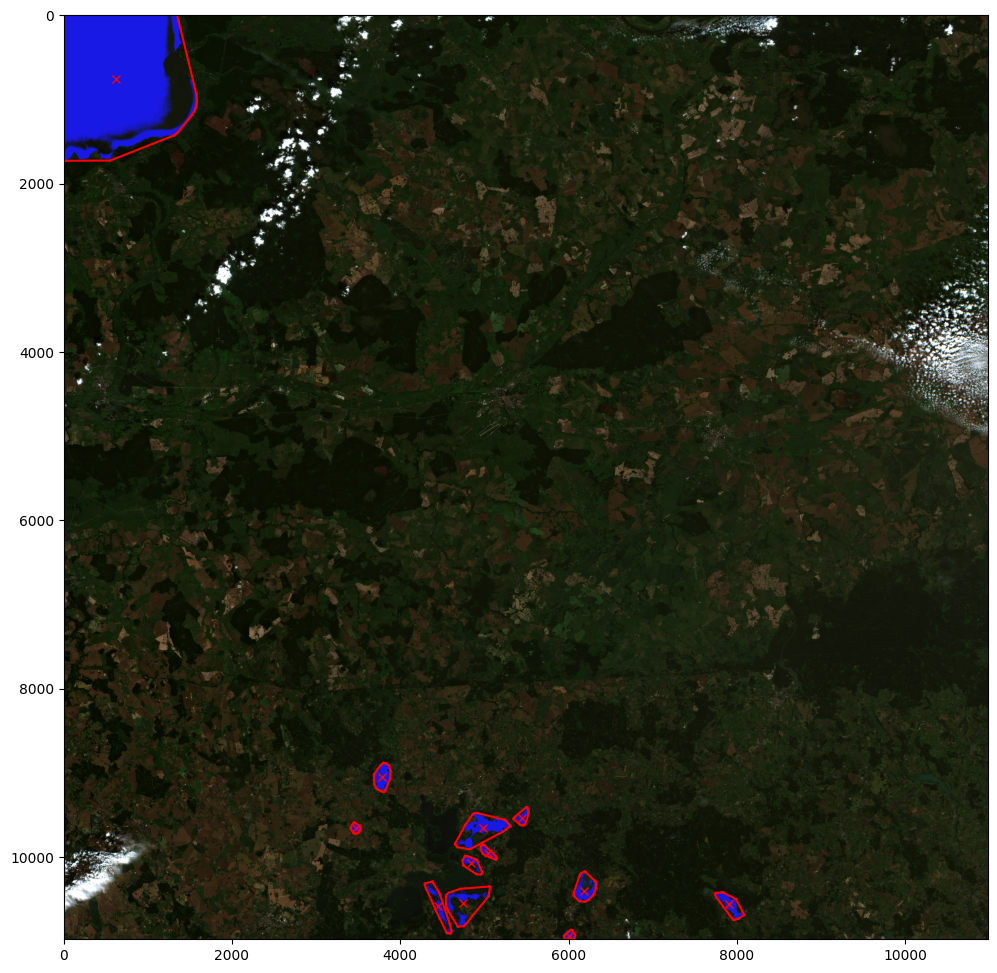

In [41]:
from scipy.spatial import ConvexHull


rgb = np.stack([img['B04'], img['B03'], img['B02']], axis=-1)
rgb = rgb/rgb.max() * 5

X = water_indexes_image_coords[:, 0]
Y = water_indexes_image_coords[:, 1]
mask_matrix = np.zeros((10980, 10980), dtype='bool')
mask_matrix[X, Y] = True
mask_matrix
rgb[mask_matrix] = [0.1, 0.1, 0.9]

plt.figure(figsize = (12, 12))
plt.imshow(rgb)


for i in cluster_indexes_above_thre:
    print(str(i))
    cluster_one_points = []

    zipped_water_clusters = zip(water_indexes, clusters.labels_)
    for point, cluster_idx in zipped_water_clusters:
        if cluster_idx == i:
            cluster_one_points.append([point[1], point[0]]) 

    cluster_one_points = np.array(cluster_one_points)


    hull = ConvexHull(cluster_one_points)

    cx = np.mean(cluster_one_points[:, 0])
    cy = np.mean(cluster_one_points[:, 1])

    print("hull length: " + str(len(hull.simplices)))
    print('Area: ' + str(len(cluster_one_points) * 100) + ' (m^2)')
    print('Area: ' + str(len(cluster_one_points) * 100 / 1000000) + ' (km^2)')

    # plt.plot(cluster_one_points[:,0], cluster_one_points[:,1], 'o')
    for simplex in hull.simplices:
        plt.plot(cluster_one_points[simplex, 0], cluster_one_points[simplex, 1], 'r-')

    plt.plot(cx, cy, 'rx', ms = 6)


plt.show()

In [ ]:
# high accuracy but slow
'''
import alphashape
from descartes import PolygonPatch
from shapely.geometry import MultiPolygon

cluster_one_points = []

zipped_water_clusters = zip(water_indexes, clusters.labels_)
for point, cluster_idx in zipped_water_clusters:
    if cluster_idx == 0:
        cluster_one_points.append([point[0], point[1]]) 

cluster_one_points = np.array(cluster_one_points)

fig, ax = plt.subplots()
ax.scatter(*zip(*cluster_one_points))
plt.title('Normal,' + ' Pixels: ' + str(len(cluster_one_points)))
plt.show()

# max = 50000

# while (len(cluster_one_points) > max):
#     print(len(cluster_one_points))
#     index = 0
#     new_cluster_one_points = []
#     for item in cluster_one_points:
#         if index % 2 == 0:
#             new_cluster_one_points.append(item)
#         index += 1
#     cluster_one_points = new_cluster_one_points

for i in range(5):
    alpha_shape = alphashape.alphashape(cluster_one_points, .1 * i)
    fig, ax = plt.subplots()
    ax.scatter(*zip(*cluster_one_points))
    ax.add_patch(PolygonPatch(alpha_shape, alpha=.4, color='blue'))
    if type(alpha_shape) == type(MultiPolygon()):
        print("tak")
        print(len(alpha_shape))
        xx = []
        yy = []
        for item in alpha_shape:
            xxx, yyy = item.exterior.coords.xy
            xx += xxx
            yy += yyy
        plt.title('Alpha: ' + str(.1 * i) + ' Polygons length: ' + str(len(xx)))
    else:
        xx, yy = alpha_shape.exterior.coords.xy
        plt.title('Alpha: ' + str(.1 * i) + ' Polygons length: ' + str(len(xx.tolist())))
    plt.show()
'''
print()

In [ ]:
# import utm

# print(water_cluster_points)

# for idx, cor in water_cluster_points.items():
#     water_cluster_points[idx] = utm.to_latlon(cor[0], cor[1], 34, 'U')  # 33 - left part of Poland, 34 - right part of Poland

# print(list(water_cluster_points.items())[:10])

In [ ]:
from pyproj import transform
from rasterio.crs import CRS
from rasterio.warp import transform

zipped_final_result = zip(water_cluster_points, water_indexes_real_coords)
new_crs = CRS.from_epsg(4326)

export_to_db_dic = {}

for result in list(zipped_final_result):
    new_coo = transform(dataset2.crs, new_crs, xs=[result[1][0]], ys=[result[1][1]])
    export_to_db_dic[result[0]] = [new_coo[1][0], new_coo[0][0]]

export_to_db_dic


{0: [55.04698603153837, 20.999686980376268],
 54: [54.2472672223876, 21.58271842653359],
 59: [54.1983677088979, 21.84216306885771],
 64: [54.19266073865039, 21.75391702182309],
 72: [54.18397463696728, 21.52834905566329],
 85: [54.15908090195105, 21.7626483874136],
 99: [54.14705799974809, 21.730276297258655],
 108: [54.12909932825082, 21.947117652384584],
 124: [54.119998050119435, 21.669518372196475],
 134: [54.114164996823376, 21.772991169832792],
 148: [54.104409713653844, 22.19631851699858],
 195: [54.06664345066743, 21.922469135107754]}

In [ ]:
from ibmcloudant.cloudant_v1 import CloudantV1, Document
from ibm_cloud_sdk_core.authenticators import IAMAuthenticator
import time

authenticator = IAMAuthenticator("")
service = CloudantV1(authenticator=authenticator)
service.set_service_url("")

for cluster_point in list(export_to_db_dic.items()):
    print(cluster_point)
    doc_sample = Document(
        type="Feature",
        properties={"idx": int(cluster_point[0])},
        geometry={
            "type": "Point",
            "coordinates": [cluster_point[1][1], cluster_point[1][0]],
        }
    )
    service.put_document(db='senti-water-points', doc_id=str(cluster_point[0]), document=doc_sample)
    time.sleep(0.25)

(0, [55.04698603153837, 20.999686980376268])


ValueError: The service_url is required

In [ ]:
# import fiona
# from shapely.geometry import Point, mapping

# schema = {'geometry': 'Point', 'properties': {'idx': 'int'}}

# with fiona.open('shp/punkty.shp', 'w', crs = dataset.crs.to_wkt(), driver = 'ESRI Shapefile', schema = schema) as output:
#     for idx, coordinates in water_cluster_points.items():
#         point = Point(float(coordinates[0]), float(coordinates[1]))
#         prop = {'idx': int(idx)}
#         output.write({'geometry': mapping(point), 'properties': prop})

# # sprawdzenie
# c = fiona.open('shp/punkty.shp', 'r')
# print(len(c))
# print(next(iter(c)))
# print(c.crs)
# print(c[100])

210
{'type': 'Feature', 'id': '0', 'properties': OrderedDict([('idx', 0)]), 'geometry': {'type': 'Point', 'coordinates': (55.04698603069178, 20.999686980376282)}}
{'init': 'epsg:32634'}
{'type': 'Feature', 'id': '100', 'properties': OrderedDict([('idx', 99)]), 'geometry': {'type': 'Point', 'coordinates': (54.60826801564791, 22.546270524951776)}}
